In [0]:
!pip install -q sk-video
!pip install -q pims
!pip install opencv-wrapper

In [0]:
import imutils
import json
import time
import cv2
import pims
import matplotlib.pyplot as plt
from skvideo.io import FFmpegWriter
import skvideo
import numpy as np
import math
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing
from skimage.filters.rank import entropy
import opencv_wrapper as cvw
from sklearn.cluster import KMeans

from google.colab import drive
drive.mount('/content/gdrive')


In [0]:
# Show image
def imshow(img):
    fig, ax = plt.subplots(figsize=(13,13))
    ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

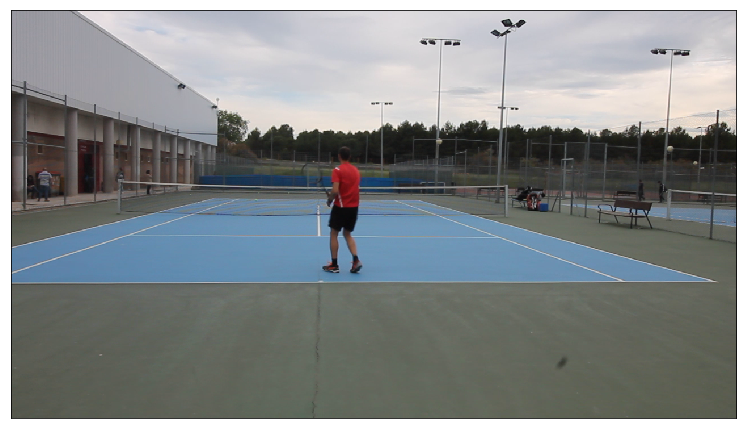

In [0]:
# Read image
line_image = cv2.imread('/content/gdrive/My Drive/videos/day_lines.png', cv2.IMREAD_COLOR)

In [0]:
# Draw lines in a image
def draw_lines(img,lines,widht =1):
  
  out_img = img.copy()
  if lines is not None:
    for line in lines:
      x1, y1, x2, y2 = line
      cv2.line(out_img, (x1, y1), (x2, y2), (0, 255, 0), widht)  
      
  return out_img

# Draw detected lines in image, and return it among with lines
def get_lines(in_img,frame,roi_polygon):

  edges = cv2.Canny(in_img, 0, 255)
  edges = roi(edges,roi_polygon)
  lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, maxLineGap=250)
  lines = np.reshape(lines,(lines.shape[0],lines.shape[2]))
  
  out_img = draw_lines(frame,lines,2)
  
  return out_img, lines
 
# Create Region of Interest in image, from a list of vertices
def roi(img,vertices):

  mask = np.zeros_like(img)
  cv2.fillConvexPoly(mask, vertices, (255,255,255))
  masked = cv2.bitwise_and(img, mask)
  return masked  


In [0]:
# Process k-means algorithm to a image
def get_kmeans(img,klusters):
  
  image = img.copy()
  image = image.reshape((image.shape[0] * image.shape[1], 3))

  clt = KMeans(n_clusters = klusters)
  clt.fit(image)
  
  return clt

# Apply k-means mask (put zeros) in img, then threshold
def get_mask_kmeans(img,klusters,cut):

  clt = get_kmeans(img,klusters)
  
  labels = clt.labels_.reshape(img.shape[0],img.shape[1])
  
  image = img.copy()

  unique, counts = np.unique(labels, return_counts=True)
  sorted_counts = np.flip(np.sort(counts))

  for c in range(cut):
    index = np.where(counts == sorted_counts[c])
    cluster = unique[index]
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        if labels[i,j]== cluster:
          image[i,j,:] = 0
  
  image2 = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  image2 = cv2.threshold(image2, 5, 255,cv2.THRESH_BINARY)[1]
  
  return image,image2


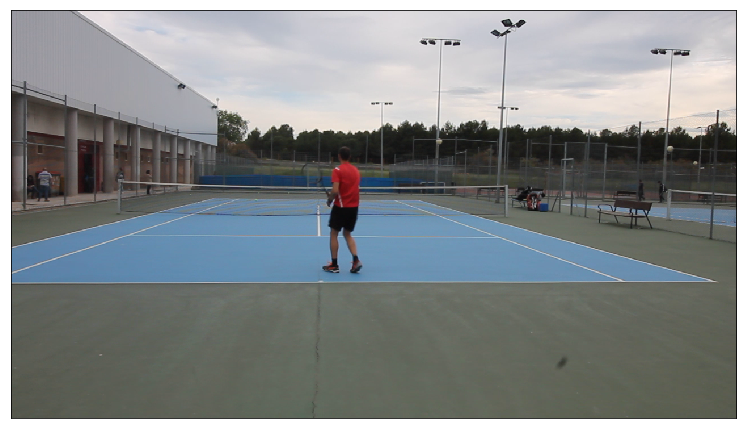

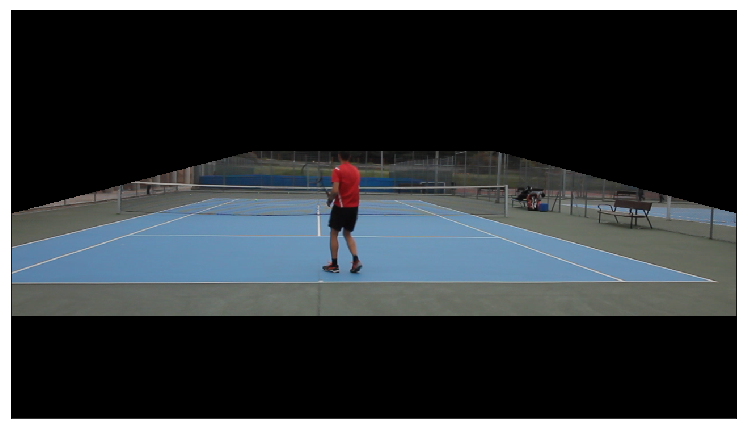

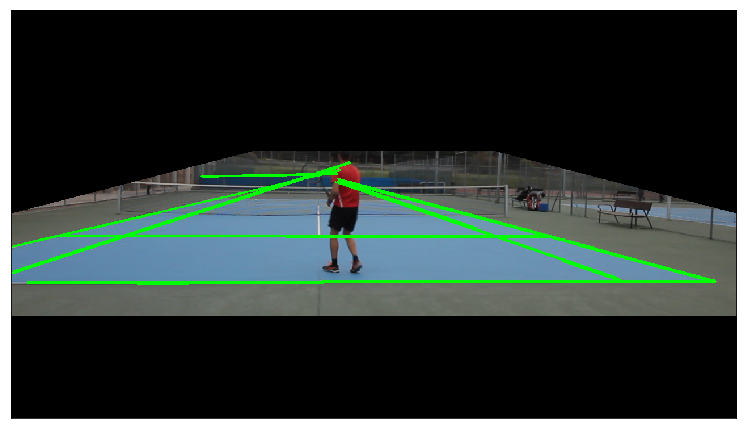

In [0]:
frame = line_image.copy()

# Roi polygons
image_cut = 250
roi_margin = 3
roi_polygon = np.array([ [0 , frame.shape[0] * 3 // 4],   [0 , (frame.shape[0] // 2)], 
                              [frame.shape[1] // 3 , image_cut],   [frame.shape[1] * 2 // 3 , image_cut],
                              [frame.shape[1] , frame.shape[0] // 2], [frame.shape[1] , frame.shape[0] * 3 // 4]
                            ], np.int32)

canny_roi_polygon = np.array(
        [ [0 + roi_margin, (frame.shape[0] * 3 // 4) - roi_margin] ,   [0 + roi_margin, (frame.shape[0] // 2) + roi_margin], 
          [(frame.shape[1] // 3) + roi_margin, image_cut + roi_margin],   [(frame.shape[1] * 2 // 3) - roi_margin, image_cut + roi_margin],
          [frame.shape[1] - roi_margin, (frame.shape[0] // 2) + roi_margin], [frame.shape[1] - roi_margin, (frame.shape[0] * 3 // 4) - roi_margin]
        ], np.int32)

# Show original image
imshow(frame)

# Apply ROI to image, a gray version
frame = roi(frame,roi_polygon)  
gray = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)

# Apply two times k-means
mask_kmeans,aux = get_mask_kmeans(frame,10,5)
aux,mask_kmeans = get_mask_kmeans(mask_kmeans,10,5)

# Get Canny mask
mask_canny = cv2.Canny(gray, 0, 255)  

# Show croped images
imshow(frame)

# Mix Canny and kmeans masks
and_canny_kmeans = cv2.bitwise_and(mask_canny,mask_canny,mask=mask_kmeans).astype(np.uint8)  

# Get Hough lines
out_frame,lines = get_lines(and_canny_kmeans,frame,canny_roi_polygon)

# Show result
imshow(out_frame)
  

In [0]:
# Get slope of a line
def get_slope (l):
  return (l[3]-l[1])/(l[2]-l[0])

# Get x coordinate from x1,y1,y2,slope
def get_x (x1,y1,y2,slope):
  return (y2 -y1 + (slope * x1))// slope

# Get y coordinate from x1,y1,y2,slope
def get_y (x1,y1,x2,slope):
  return (slope * x2) - (slope * x1) + y1

# Max x value of a segment
def max_x(l):
  return max(l[0],l[2])

# Max y value of a segment
def max_y(l):
  return max(l[1],l[3])

# Min x value of a segment
def min_x(l):
  return min(l[0],l[2])

# Min y value of a segment
def min_y(l):
  return min(l[1],l[3])  

# Permute
def perp( a ):
  
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# Intersect of two lines
def seg_intersect(l1,l2):
  
    a1 = np.array([l1[0],l1[1]])
    a2 = np.array([l1[2],l1[3]])
    b1 = np.array([l2[0],l2[1]])
    b2 = np.array([l2[2],l2[3]])
    
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

# Get line enclosed by limits  
def get_intersection_segment(line,limit1,limit2):
  
  intersect = seg_intersect(line,limit1)
  line[0] = int(intersect[0])
  intersect = seg_intersect(line,limit2)
  line[2] = int(intersect[0])
  
# Classify lines accordint to slope
def sort_lines(lines):

  horizontal = []
  vertical = []
  left = []
  right = []

  for l in lines:
    slope = get_slope(l)
    if abs(slope) < 0.02:
      horizontal.append(l)
    elif abs(slope) > 0.99:
      vertical.append(l)
    elif slope < 0 and abs(slope) < 0.40 and abs(slope) > 0.20:
      left.append(l)
    elif slope > 0 and abs(slope) < 0.40 and abs(slope) > 0.20:
      right.append(l)

  return horizontal,vertical,left,right    

# Get horizontal line with highest y coordenate, and fit all near lines in 12 pixels
def max_horizontal_line(lines):

  lines = np.array(lines)

  max_values =  np.amax(lines, axis=0)
  max_value = max_y(max_values)
  lw_margin = max_value -12
  hg_margin = max_value 
  baseline = []
  index_delete = []

  for i in range(len(lines)):
    l = lines[i]
    max_i = max_y(l)
    if max_i <= hg_margin and max_i >= lw_margin:
      index_delete.append(i)    
      baseline.append(l)

  lines = np.delete(lines,index_delete,axis=0)
  
  min_h = np.amin(baseline,axis=0)
  max_h = np.amax(baseline,axis=0)
  mean_h = np.median(baseline,axis=0).astype(np.int)

  baseline = [min_x(min_h),mean_h[1],max_x(max_h),mean_h[3]]
  return lines,baseline

# Get k lines after apply k-means, in order to classify different vertical lines
def get_k_means_lines(lines,baseline,min_y,n_k = 2):

  x_inters = []
  for i,line in enumerate(lines):
    x_inters.append(seg_intersect(baseline,line))

  clt = KMeans(n_clusters = n_k)
  clt.fit(np.array(x_inters))

  angle_sum_labels = listofzeros = [0] * n_k
  for i,label in enumerate(clt.labels_):
    angle_sum_labels[label] += get_slope(lines[i])

  unique, counts = np.unique(clt.labels_, return_counts=True)
  angle_sum_labels /= counts
  
  out_lines = []
  sorted_cluster_centers = np.sort(clt.cluster_centers_[:,[0]],axis=0)
  sorted_cluster_centers = np.reshape(sorted_cluster_centers,sorted_cluster_centers.shape[0])
  for clu in sorted_cluster_centers:
    i = np.int32(np.where(clt.cluster_centers_[:,0] == clu)[0][0])
    x = get_x(clt.cluster_centers_[i,0],clt.cluster_centers_[i,1],min_y,angle_sum_labels[i])
    out_lines.append([int(clt.cluster_centers_[i,0]),int(clt.cluster_centers_[i,1]),int(x),min_y])
  
  return out_lines

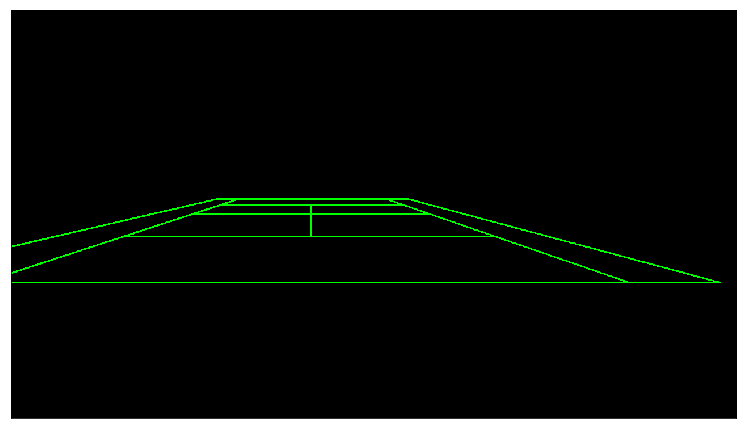

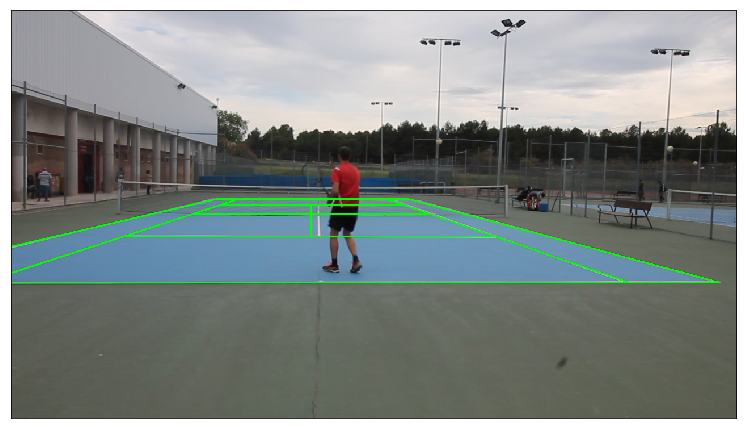

In [0]:

# Get horizontal lines
horizontal,vertical,left,right = sort_lines(lines)
horizontal,baseline = max_horizontal_line(horizontal)
horizontal,serveline = max_horizontal_line(horizontal)

# Get singles and dobles lines
side_lines = np.array(right)
side_lines = np.append(right,left,axis=0)
side_lines = get_k_means_lines(side_lines,baseline,300,4)

# Adjust base and serveline to side_lines
get_intersection_segment(baseline,side_lines[0],side_lines[3])
get_intersection_segment(serveline,side_lines[1],side_lines[2])

# Angle/distance/height parameter to adjust
camera_distance = 7.7 # para dia

# Court measures
baseline_serviceline = 5.845
serviceline_net = 6.4

# Calculate depth pixel reduction 
pixel_meter_baseline = (frame.shape[0] - baseline[3]) / camera_distance
pixel_meter_serveline = (baseline[3]-serveline[3]) / baseline_serviceline
pixel_reduction = pixel_meter_serveline / pixel_meter_baseline

# Get slope of baseline
slope = get_slope(baseline)

# Model netline
current_pixel_meter = pixel_meter_serveline * (pixel_reduction * 1) 
y_aux = serveline[1] - int((current_pixel_meter * serviceline_net)) 
y_aux2 = int(get_y(serveline[0],y_aux,serveline[2],slope))

# Adjust to side lines
netline = [serveline[0],y_aux,serveline[2],y_aux2]
get_intersection_segment(netline,side_lines[1],side_lines[2])

# Get slope of netline
slope = get_slope(netline)

# Model opposite serveline
current_pixel_meter = current_pixel_meter * (pixel_reduction * 1)
y_aux = netline[1] - int((current_pixel_meter * serviceline_net)) 
y_aux2 = int(get_y(netline[0],y_aux,netline[2],slope))

# Adjust to side lines
serveline2 = [netline[0],y_aux,netline[2],y_aux2]
get_intersection_segment(serveline2,side_lines[1],side_lines[2])

# Model opposite baselin
current_pixel_meter = current_pixel_meter * (pixel_reduction * 1.5)   
y_aux = serveline2[1] - int((current_pixel_meter * baseline_serviceline)) 
y_aux2 = int(get_y(serveline2[0],y_aux,serveline2[2],slope))

# Adjust to side lines
baseline2 = [serveline2[0],y_aux,serveline2[2],y_aux2]
get_intersection_segment(baseline2,side_lines[0],side_lines[3])

# Get vertical_serveline
for l in side_lines:
  intersect = seg_intersect(l,baseline2)
  l[2] = int(intersect[0])
  l[3] = int(intersect[1])
vertical_serveline = [(netline[0] + netline[2]) // 2, serveline[1],(netline[0] + netline[2]) // 2, serveline2[1]]

# Prepare lines arrays
lines_frame = np.zeros_like(out_frame)

n_lines = np.array([baseline,serveline])
n_lines = np.append(n_lines,side_lines,axis=0)
net_line = np.array([netline,serveline2,baseline2,vertical_serveline])
n_lines = np.append(n_lines,net_line,axis=0)

# Show Model and Original + Model Lines
imshow(draw_lines(lines_frame,n_lines,2))
i = line_image.copy()
imshow(draw_lines(i,n_lines,2))
